In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns

from cue.analysis.analysis import bootstrap_ci

/home/jgosmann/.virtualenvs/cue/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from cue.utils.plotting import *

In [3]:
style()

In [4]:
data = np.load('result.npz')

In [5]:
list(data.keys())

['trial',
 'ordinal_prob',
 'vocab_vectors',
 'p_ctx_spikes',
 'noise',
 'positions',
 't',
 'p_recalls',
 'distractor_rate',
 'seed',
 'timings',
 'vocab_keys',
 'pos_vectors',
 'p_pos',
 'min_evidence',
 'pos_keys',
 'responses']

In [6]:
raw_spikes = data['p_ctx_spikes']

In [7]:
t = data['t'][0]

In [8]:
timings = np.sort(data['timings'], axis=1) + 1.2 * 12 # + 16
responses = data['responses']

In [9]:
pi_epochs = [list(range(1200 * i, 1200 * (i+1))) for i in range(12)]

# Context similarity

In [10]:
dfs_recall = defaultdict(list)
dfs_pres = defaultdict(list)
for i, trial_data in enumerate(raw_spikes):
    events = list(np.take(trial_data, pi_epochs, axis=0))
    r_pos = []
    
    firing = [np.sum(e, axis=0) / 1200. for e in events]
    z_scores = (firing - np.mean(firing, axis=0, keepdims=1)) / np.std(firing, axis=0, keepdims=1)
    
    for k in range(len(events)):
        df = pd.DataFrame({
            'trial': [i] * 800,
            'unit': range(800),
            'z-score': z_scores[k]
        }).dropna().set_index(['trial', 'unit'])
        if k < 12:
            dfs_pres[k].append(df)
        else:
            dfs_recall[r_pos[k - 12]].append(df)
            
dfs_pres = {k: pd.concat(v) for k, v in dfs_pres.items()}
dfs_recall = {k: pd.concat(v) for k, v in dfs_recall.items()}

/home/jgosmann/.virtualenvs/cue/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [11]:
def calc_recency_sim(pos):
    similarity = (
        (dfs_pres[11] * dfs_pres[pos]).dropna().groupby('trial').sum() / 800.)['z-score']
    μ = similarity.mean()
    ci_low, ci_up = bootstrap_ci(similarity, np.mean)
    return μ, (μ - ci_low, ci_up - μ)

In [12]:
x = np.arange(12)
recency = x - 11
similarity_mean, similarity_ci = zip(*(calc_recency_sim(a) for a in x))

# Context reinstantion

In [13]:
dfs_pres = defaultdict(list)
dfs_pre = defaultdict(list)
dfs_post = defaultdict(list)
for i, trial_data in enumerate(raw_spikes):
    events = list(np.take(trial_data, pi_epochs, axis=0))
    events_post = []
    events_pre = []
    r_pos = []
    for j in range(12):
        if not np.isnan(responses[i, j]):
            first_index = int(timings[i, j] * 1000)
            end_index = timings[i, j+1]
            if np.isnan(end_index):
                end_index = len(trial_data)
            else:
                end_index = int(1000 * end_index)
            events_post.append(trial_data[first_index:end_index, :])
            events_pre.append(trial_data[first_index - 1200:first_index, :])
            r_pos.append(responses[i, j])
    
    xevents = events + events_pre + events_post
    firing = [np.mean(e, axis=0) for e in xevents]
    z_scores = (firing - np.mean(firing, axis=0, keepdims=1)) / np.std(firing, axis=0, keepdims=1)
    
    for k in range(len(events)):
        df = pd.DataFrame({
            'trial': [i] * 800,
            'unit': range(800),
            'z-score': z_scores[k]
        }).dropna().set_index(['trial', 'unit'])
        dfs_pres[k].append(df)
    for k in range(len(events_pre)):
        df = pd.DataFrame({
            'trial': [i] * 800,
            'unit': range(800),
            'z-score': z_scores[k + len(events)]
        }).dropna().set_index(['trial', 'unit'])
        dfs_pre[r_pos[k]].append(df)
        df = pd.DataFrame({
            'trial': [i] * 800,
            'unit': range(800),
            'z-score': z_scores[k + len(events) + len(events_pre)]
        }).dropna().set_index(['trial', 'unit'])
        dfs_post[r_pos[k]].append(df)

dfs_pres = {k: pd.concat(v) for k, v in dfs_pres.items()}          
dfs_pre = {k: pd.concat(v) for k, v in dfs_pre.items()}
dfs_post = {k: pd.concat(v) for k, v in dfs_post.items()}

/home/jgosmann/.virtualenvs/cue/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [14]:
def restore_ind(pos, cmp_data, label):
    y = (dfs_pres[pos] * cmp_data[pos]).dropna().groupby('trial').sum()['z-score'] / 800.
    return pd.DataFrame({
        label: y,
        'pos': [pos] * len(y)
    }).reset_index().set_index(['pos', 'trial'])

In [15]:
pre = pd.concat([restore_ind(a, dfs_pre, 'pre') for a in range(12)])
post = pd.concat([restore_ind(a, dfs_post, 'post') for a in range(12)])

In [16]:
df = pre.merge(post, left_index=True, right_index=True).reset_index()
df['diff'] = df['post'] - df['pre']

In [17]:
reinst_mean = np.mean(df['diff'])
reinst_ci = bootstrap_ci(df['diff'], np.mean)

In [18]:
print(reinst_mean)
print(reinst_ci)

0.12845138
(0.11092464, 0.14505358)


In [19]:
ttest_ind(df['pre'], df['post'])

Ttest_indResult(statistic=-9.525514655620722, pvalue=1.3186972347329564e-20)

# Plot

In [20]:
reinst_dl = (reinst_mean - reinst_ci[0]) / np.sqrt(2.)
reinst_du = (reinst_mean + reinst_ci[1]) / np.sqrt(2.)

pre_mean = np.mean(df['pre'])
post_mean = np.mean(df['post'])

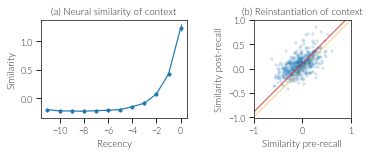

In [21]:
fig = plt.figure(figsize=(textwidth, row_height))

ax = fig.add_subplot(1, 2, 1)
ax.errorbar(recency, similarity_mean, np.asarray(similarity_ci).T, marker='o', markersize=3)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Recency")
ax.set_ylabel("Similarity")
ax.set_title("(a) Neural similarity of context")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(x='pre', y='post', data=df, marker='+', ax=ax, linewidth=0.2)
ax.set_aspect(1.)
extends = np.array([-1., 1.])
ax.plot(extends, extends, c='orange', linewidth=0.5)
ax.fill_between(
    extends,
    extends + reinst_ci[0],
    extends + reinst_ci[1],
    color='tab:red', alpha=0.75, lw=0)
ax.set_xlim(-1., 1)
ax.set_ylim(-1., 1)
ax.set_xlabel("Similarity pre-recall")
ax.set_ylabel("Similarity post-recall")
ax.set_title("(b) Reinstantiation of context")

sns.despine(fig, top=False, right=False)
fig.tight_layout()

In [22]:
save_tight_fig(fig, './neural-context.pdf')